In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data_without_labels.csv")

In [3]:
normal_data = data[data['Labels'] == 0]
minor_data = data[data['Labels'] == 1]
print(normal_data.shape)
print(minor_data.shape)

(283301, 12)
(2747, 12)


In [4]:
from sklearn.preprocessing import StandardScaler

for col in list(data):
    print(col)
    if col != "Observation_ID" and col != "Labels":
        normal_data[col] = StandardScaler().fit_transform(normal_data[col].values.reshape(-1, 1))
        minor_data[col] = StandardScaler().fit_transform(minor_data[col].values.reshape(-1, 1))
        data[col] = StandardScaler().fit_transform(data[col].values.reshape(-1, 1))

Observation_ID
Elevation


C:\Users\chali\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\chali\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\chali\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Aspect
Slope
Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Hillshade_9am
Hillshade_Noon
Hillshade_3pm
Horizontal_Distance_To_Fire_Points
Labels


In [5]:
labels = data['Labels']

del data['Labels']
del data['Observation_ID']

del normal_data['Labels']
del normal_data['Observation_ID']

del minor_data['Labels']
del minor_data['Observation_ID']

X_train = normal_data.values
X_test = data.values
print(X_train.shape)
print(X_test.shape)

(283301, 10)
(286048, 10)


In [6]:
input_layer = Input(shape=(10, ))
encoder = Dense(9, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(8, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(7, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(6, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(5, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(4, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(3, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(3, activation='tanh')(encoder)
decoder = Dense(4, activation='tanh')(decoder)
decoder = Dense(5, activation='tanh')(decoder)
decoder = Dense(6, activation='tanh')(decoder)
decoder = Dense(7, activation='tanh')(decoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(9, activation='tanh')(decoder)
decoder = Dense(10, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [7]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [ ]:
nb_epoch = 5
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [8]:
autoencoder = load_model('model.h5')

In [9]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels})
error_df.describe()

,reconstruction_error,true_class
count,286048.000000,286048.000000
mean,0.562956,0.009603
std,0.480076,0.097525
min,0.026382,0.000000
25%,0.297792,0.000000
50%,0.439810,0.000000
75%,0.659809,0.000000
max,21.984575,1.000000


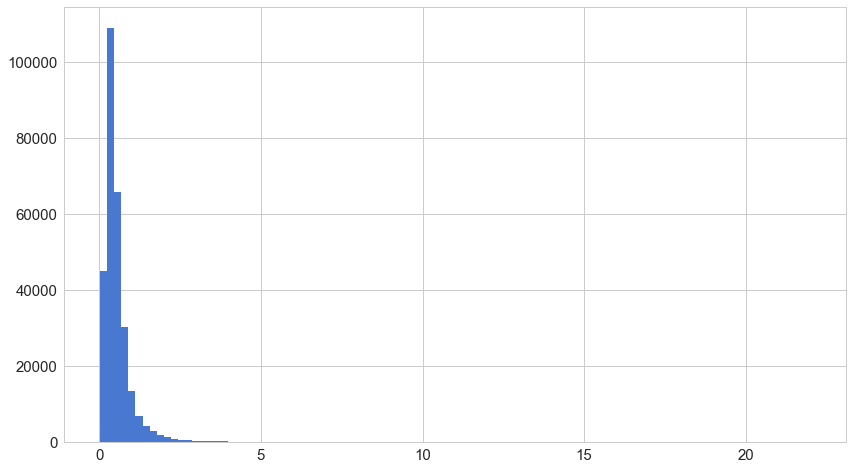

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=100)

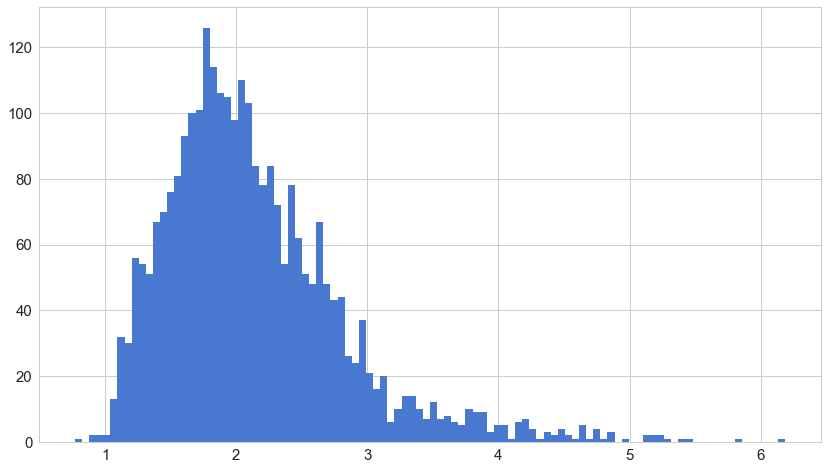

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)

In [18]:
threshold = 1.45

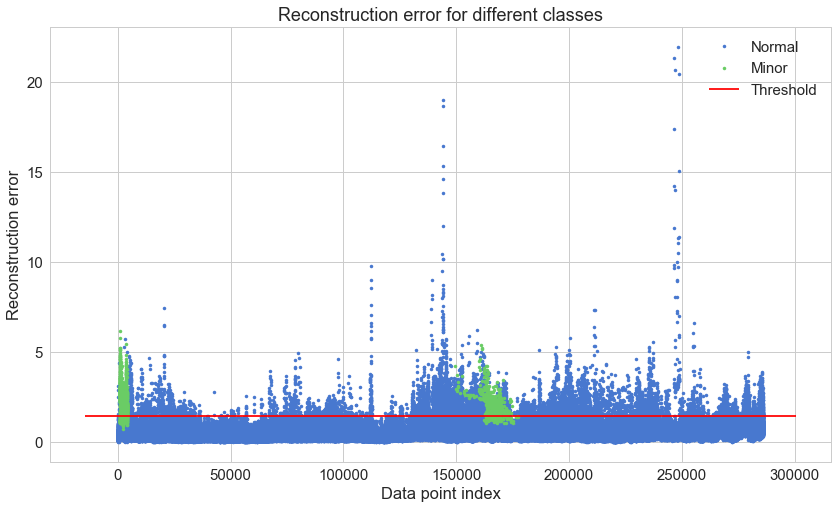

In [19]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

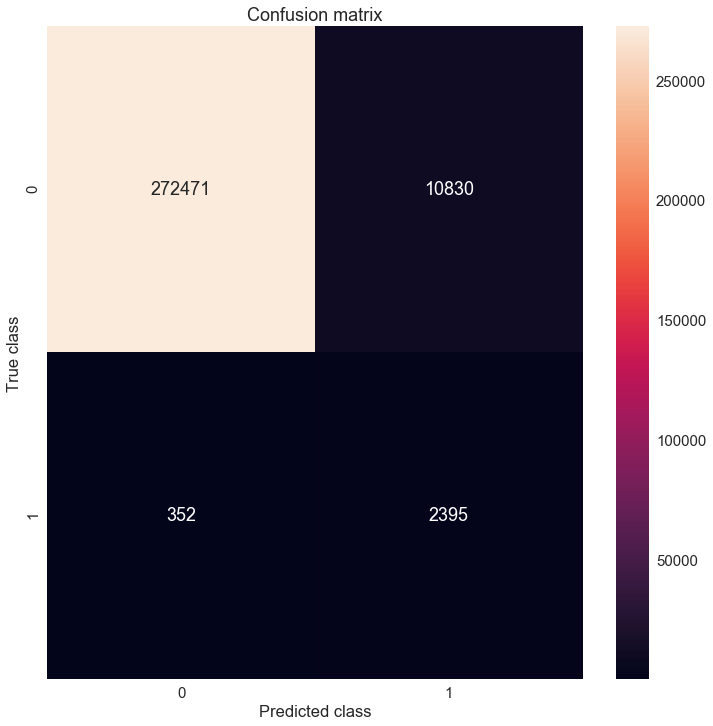

In [20]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()